In [1]:
# Ignore Warnings
from warnings import simplefilter
simplefilter('ignore')

%reload_ext autoreload
%autoreload 2

In [2]:
# Dependencies - General Stuff
import sys
import os
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from glob import glob
from scipy.signal import windows, fftconvolve
from scipy.io import wavfile
from scipy.special import genlaguerre
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
import seaborn as sns

# Depednecies from Theunissen Lab
# sys.path.append("/Users/frederictheunissen/Code/soundsig/")
from soundsig.sound import BioSound
from soundsig.sound import spec_colormap

# strfpy
from strfpy.makePSTH import SpikeResponse
from strfpy import findDatasets, preprocSound, strfSetup, trnDirectFit, plotTfrep
# from strflab import preprocess_sound, srdata2strflab, linInit, strfData, trnDirectFit, strfOpt


# %matplotlib widget
plt.ion();

In [3]:
path_base = '/aquila_ssd2/lthomas/Projects/pySTRF_exampledata'
# dataDir = os.path.join(path_base, 'data')  # contains stim/response pairs
stimsDir = os.path.join(path_base, 'all_stims')  # contains the .wav files

# Specify the directory for three brain regions and three example neurons in each
cellDirName = 'l2a_good'
cellDir = os.path.join(path_base,cellDirName, 'conspecific')

# Get the stimulus and response files from the cell directory
datasets = findDatasets.find_datasets(cellDir, stimsDir)
cellStimDir = datasets['dirname']
stimFiles = datasets['srPairs']['stimFiles']  # paths to .wav files
respFiles = datasets['srPairs']['respFiles']  # paths to spike* files

# Preprocess the sound stimuli by taking the short time Fourier transform, and preprocess the raw spike
# times into PSTHs for each stim/response pair.
preprocDir = os.path.join(cellStimDir, 'preproc') # cache the preprocessed data here
os.makedirs(preprocDir, exist_ok=True)
preprocOptions = {} # we'll leave this empty and use default options


In [4]:
# set up datasets
srData = preprocSound.preprocess_sound(stimFiles, respFiles, preprocess_type='ft', stim_params = preprocOptions, output_dir = preprocDir)
pairCount = len(srData['datasets']) # number of stim/response pairs
nStimChannels = srData['nStimChannels']


In [5]:
# Lets set up our parameters for the model
respChunkLen = 250 # length of the response chunk to use for training
segmentBuffer = 100 # number before the response chunk to include in the segment
nLaguerre = 15 # number of laguerre functions to use
feature = 'spect_windows' # feature to use for the model
event_types = 'onoff_feature' # event types to use for the model
nPoints = 150 # number of points to use for the model kernel

In [6]:
# Generate the event features for this dataset
from strfpy.calcSegmentedModel import preprocess_srData

# This function goes through each stim/response pair and finds onsets and offsets
# based on derivatives of the stimulus. It then adds event info into the srData dictionary
preprocess_srData(srData, plot=False, respChunkLen=respChunkLen, tdelta=0)


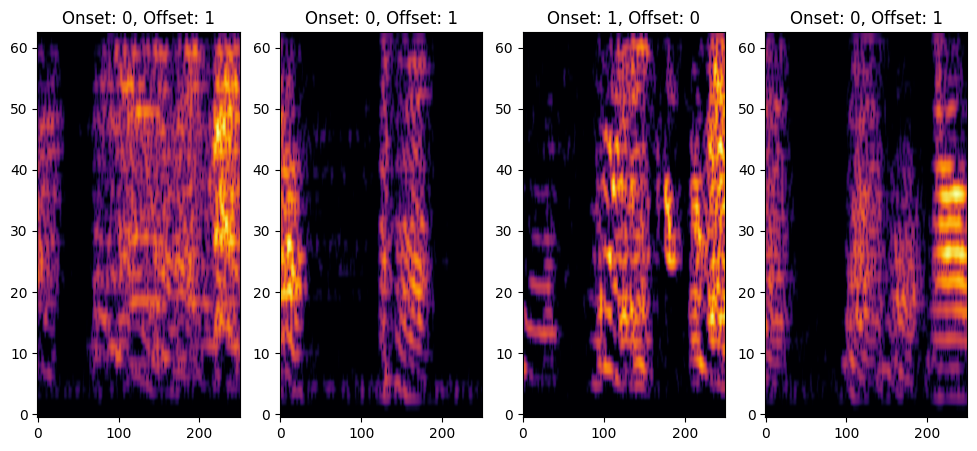

In [7]:
# Lets view some of the spectrograms
fig, ax = plt.subplots(1,4, figsize=(12,5))
for i in range(4):
    rand_idx = np.random.randint(0, len(srData['datasets']))
    specs = srData['datasets'][rand_idx]['events']['spect_windows']
    on_off_feats = srData['datasets'][rand_idx]['events']['onoff_feature']
    rand_ind = np.random.randint(0, len(specs))
    rand_spect = specs[rand_ind]
    ax[i].imshow(rand_spect, aspect='auto', origin='lower', cmap='inferno')
    on_off = on_off_feats[rand_ind]
    ax[i].set_title(f'Onset: {on_off[0]}, Offset: {on_off[1]}')
    # colorbar
    #cbar = ax[i].figure.colorbar(ax[i].imshow(rand_spect, aspect='auto', origin='lower', cmap='inferno'), ax=ax[i])

In [9]:
# now we can fit the strf model 
# this can be done directly using fit_seg_model, however stepping through this function is advised
# it comes down to three steps:
# 1. Fitting the SEGMENTATION Only Model
# 2. Fitting Laguerre parametesr to the segmentation kernel
# 3. Fitting the full model with the fixed laguerre parameters
from strfpy.calcSegmentedModel import fit_seg_model


pcaStim, SIModel_ridge, SegModel_ridge, laguerre_args = fit_seg_model(srData, nLaguerre, nPoints, event_types, feature)

Fitting PCA
Fitting convolutional kernel
Fitting laguerre parameters
Removing average response to onsets and offsets
Fit the laguerre features to the response residual


## Breakdown of the process

In [21]:
# the first step is to do dimensionality reduciton on the feature space

nEventTypes =  srData['datasets'][0]['events'][event_types].shape[1]
nfeats = srData['datasets'][0]['events']['%s_nfeats'%feature]
pairCount = len(srData['datasets'])
spect_shape = srData['datasets'][0]['events'][feature][0].shape
all_spect_windows = np.concatenate([np.asarray(srData['datasets'][iSet]['events'][feature]).reshape((len(srData['datasets'][iSet]['events']['index']), nfeats)) for iSet in range(pairCount)], axis=0)

pair_train_set = np.arange(pairCount)

# 1. first use PCA to reduce dim of the features'
print("Fitting PCA")
npcs = 20
pca = PCA(n_components=npcs)
pca.fit(all_spect_windows)

for iSet in range(pairCount):
    events = srData['datasets'][iSet]['events'][event_types]
    n_events = len(srData['datasets'][iSet]['events']['index'])
    spect_pca_features = pca.transform(srData['datasets'][iSet]['events'][feature].reshape((n_events, nfeats)))
    srData['datasets'][iSet]['events']['pca_%s'%feature] = np.zeros((n_events, nEventTypes*npcs))
    for iEventType in range(events.shape[1]):
        srData['datasets'][iSet]['events']['pca_%s'%feature][events[:,iEventType]==1,iEventType*npcs:(iEventType+1)*npcs] = spect_pca_features[events[:,iEventType]==1,:]


Fitting PCA


Text(0.5, 1.0, 'PC 1')

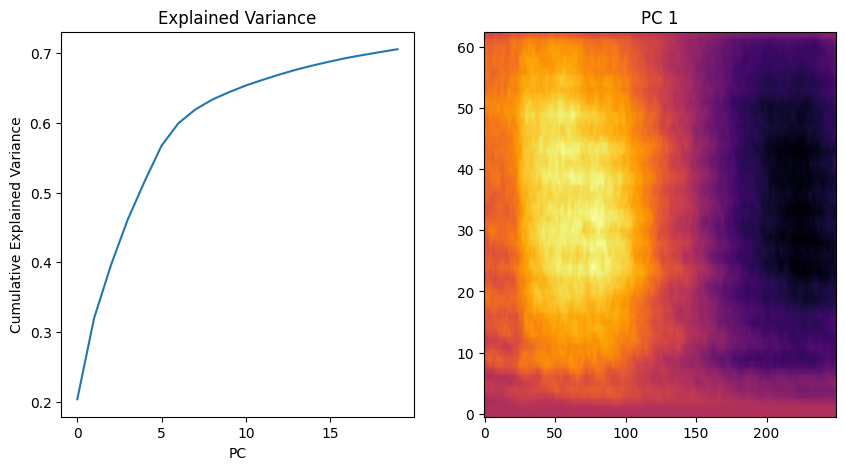

In [32]:
# we can see how well this describes the feature space by plotting the explained variance, 
# and can look at a few example PCS
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(np.cumsum(pca.explained_variance_ratio_))
ax[0].set_title('Explained Variance')
ax[0].set_xlabel('PC')
ax[0].set_ylabel('Cumulative Explained Variance')
pc_ind = np.random.randint(0, npcs, 1)
ax[1].imshow(pca.components_[pc_ind].reshape(spect_shape), aspect='auto', origin='lower', cmap='inferno')
ax[1].set_title('PC %d'%pc_ind)



In [35]:
from strfpy.calcSegmentedModel import arbitrary_kernel
# 2. now fit the onsets with a convolutional kernel
#       This removes the average response to onsets and offsets
print("Fitting convolutional kernel")
X = None
Y = None
Y_weights = None

for iSet in pair_train_set:
    pair = srData['datasets'][iSet]
    x = arbitrary_kernel(pair, nPoints=nPoints)
    if 'weights' not in pair['resp']:
        yw = np.ones_like(pair['resp']['psth_smooth'])
    else:
        yw = pair['resp']['weights']
    y = pair['resp']['psth_smooth']
    x = x[:, yw > 0]
    y = y[yw > 0]
    yw = yw[yw > 0]
    # yw = yw / np.max(yw)
    if X is None:
        X = x
    else:
        X = np.hstack([X, x])
    if Y is None:
        Y = y
        Y_weights = yw
    else:
        Y = np.hstack([Y, y])
        Y_weights = np.hstack([Y_weights, yw])

SegModel_ridge = RidgeCV()
SegModel_ridge.fit(X.T, Y, sample_weight=Y_weights)
learned_conv_kernel = SegModel_ridge.coef_.reshape(2, nPoints)


Fitting convolutional kernel


Text(0.5, 1.0, 'Offset Kernel')

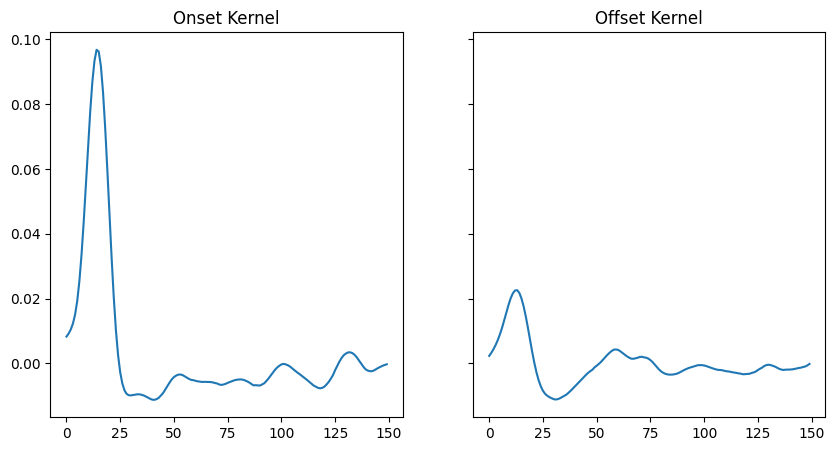

In [41]:
# to see how well that worked, we can visualize our learned kernel
fig, ax = plt.subplots(1,2, figsize=(10,5),sharey=True)
ax[0].plot(learned_conv_kernel[0])
ax[0].set_title('Onset Kernel')
ax[1].plot(learned_conv_kernel[1])
ax[1].set_title('Offset Kernel')


Text(0.5, 1.0, 'Segmentation Only Model for pair 1')

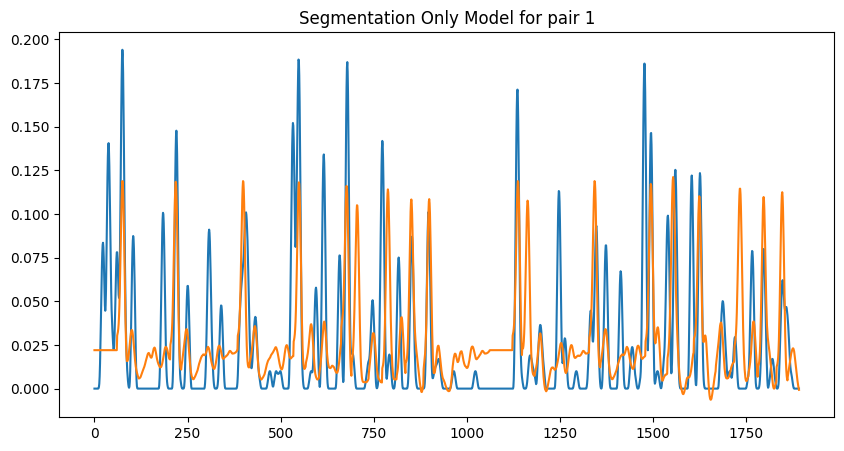

In [49]:
# and we can take a random stim-response pair and make our segment-only model of it
iSet = np.random.randint(0, pairCount, 1)
pair = srData['datasets'][iSet[0]]
x = arbitrary_kernel(pair, nPoints=nPoints)
y = pair['resp']['psth_smooth']
if 'weights' not in pair['resp']:
    yw = np.ones_like(pair['resp']['psth_smooth'])
else:   
    yw = pair['resp']['weights']
y = y[yw > 0]
x = x[:, yw > 0]
yw = yw[yw > 0]
y = y[yw > 0]
yhat = SegModel_ridge.predict(x.T)
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(y)
ax.plot(yhat)
plt.title('Segmentation Only Model for pair %d'%iSet)

In [59]:
# 3. now fit the laguerre parameters to the convolutional kernel
# this fits tau and alpha in such a way that we are able to describe the kernel with laguerre functions
from functools import partial
from strfpy.calcSegmentedModel import laguerre

print("Fitting laguerre parameters")
partial_laguerre = partial(laguerre, xorder=0)
def sum_n_laguerres(xt, *args):
    amp, tau, alpha, *w = args
    nL = len(w)
    out = np.zeros_like(xt,dtype=float)
    for iL in range(nL):
        out += w[iL] * laguerre(xt, amp, tau, alpha, xorder=iL) # TODO FIX
    return out

laguerre_args = np.zeros((nEventTypes,3))
all_args = np.zeros((nEventTypes,8))
for iEventType in range(nEventTypes):
    popt, pcov = curve_fit(sum_n_laguerres, np.arange(nPoints), learned_conv_kernel[iEventType,:], p0=[2, 6, 5,1,1,1,1,1], bounds=([ -np.inf, -np.inf, 0,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]), method='trf')
    laguerre_args[iEventType,:] = popt[:3]
    all_args[iEventType,:] = popt

Fitting laguerre parameters


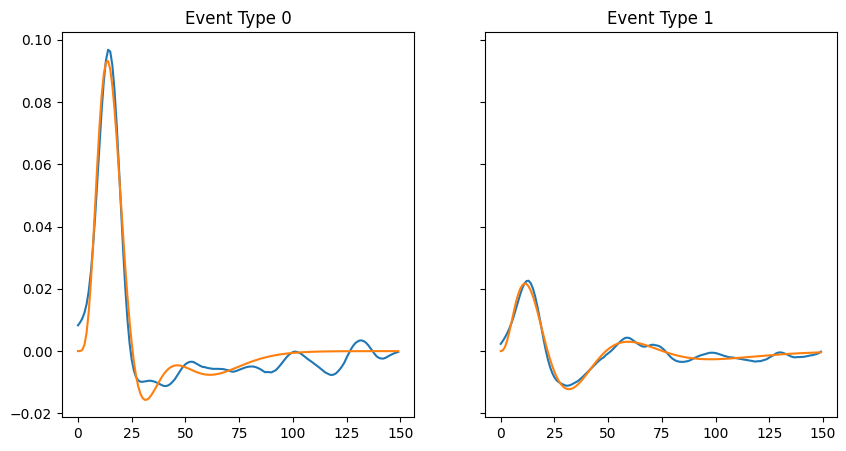

In [58]:
# to see how well that worked, we can visualize how well we fit our leanred kernel
fig, ax = plt.subplots(1,2, figsize=(10,5),sharey=True)
for iEventType in range(nEventTypes):
    ax[iEventType].plot(learned_conv_kernel[iEventType,:])
    ax[iEventType].plot(sum_n_laguerres(np.arange(nPoints), *all_args[iEventType,:]))
    ax[iEventType].set_title('Event Type %d'%iEventType)

In [61]:
# 4. now Fit the response to onsets and offsets using the features
from strfpy.calcSegmentedModel import generate_laguerre_features
print("Removing average response to onsets and offsets")
Y_avg_removed = None
Y_weights = None
X = None
for iSet in pair_train_set:
    pair = srData['datasets'][iSet]
    x = generate_laguerre_features(pair, 'pca_%s'%feature,  laguerre_args, nLaguerrePoints=nPoints, nLaguerre=nLaguerre)
    y = pair['resp']['psth_smooth']
    if 'weights' not in pair['resp']:
        yw = np.ones_like(y)
    else:
        yw = pair['resp']['weights']
    x = x[:,yw > 0]
    y = y[yw > 0]
    yw = yw[yw > 0]
    if X is None:
        X = x
    else:
        X = np.hstack([X, x])
    if Y_avg_removed is None:
        Y_avg_removed = y
        Y_weights = yw
    else:
        Y_avg_removed = np.hstack([Y_avg_removed, y])
        Y_weights = np.hstack([Y_weights, yw])

# 5. now fit the laguerre features to the response residual
print("Fit the laguerre features to the response residual")
SIModel_ridge = RidgeCV()
SIModel_ridge.fit(X.T, Y_avg_removed, sample_weight=Y_weights)


Removing average response to onsets and offsets
Fit the laguerre features to the response residual


RidgeCV()

Text(0.5, 1.0, 'Full Model for pair 10')

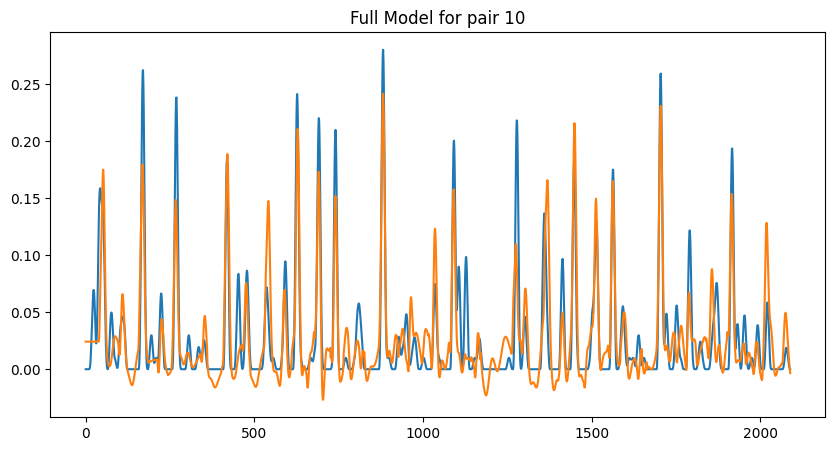

In [63]:
# we can visualize how well we fit the response to the laguerre features by looking at a random pair
iSet = np.random.randint(0, pairCount, 1)
pair = srData['datasets'][iSet[0]]
x = generate_laguerre_features(pair, 'pca_%s'%feature,  laguerre_args, nLaguerrePoints=nPoints, nLaguerre=nLaguerre)
y = pair['resp']['psth_smooth']
if 'weights' not in pair['resp']:
    yw = np.ones_like(y)
else:
    yw = pair['resp']['weights']

x = x[:,yw > 0]
y = y[yw > 0]
yw = yw[yw > 0]
yhat = SIModel_ridge.predict(x.T)
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(y)
ax.plot(yhat)
plt.title('Full Model for pair %d'%iSet)
